## Linear Regression Model

- Training data made with some overlap
- feature set 3; ie with fft components

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
from functools import reduce
from tqdm import tqdm_notebook
from sklearn.metrics import mean_absolute_error
from IPython.display import display
import gen_features
from multiprocessing import Process, Value
from sklearn.preprocessing import StandardScaler, RobustScaler, QuantileTransformer
%load_ext autoreload
%autoreload 2
%matplotlib inline
sns.set_style('whitegrid')

fset = 3

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### 1) Extract dataset with features and target from csv files

In [3]:
# Read specified chunks of training data
if "feature_set{}.csv".format(fset) not in os.listdir("Features"):
    read_chunks = list(range(1,141))
    data_list = []
    folder = "temp"
    filename = 'text.txt'
    kwargs = {'gen_features' : gen_features.gen_features3,
              'overlap_ratio' : 0.5,
             }
    for k in tqdm_notebook(read_chunks):
        p = Process(target=gen_features.gen_dim_reduced_dataset,args=(k,),kwargs=kwargs)
        p.start()
        p.join()
        if k%20 == 0:
            with open(os.path.join(folder,filename),'r') as file:
                print(file.read())
    
    data_list = [pd.read_csv(os.path.join("temp","dim_reduced_train{}.csv".format(k))).iloc[:,1:] for k in read_chunks]
    data = pd.concat(data_list,axis=0,ignore_index=True)
    data.to_csv(os.path.join("Features","feature_set{}.csv".format(fset)))
else:
    print("Feature set {} already extracted.".format(fset))
    data = pd.read_csv(os.path.join("Features","feature_set{}.csv".format(fset))).iloc[:,1:]

Feature set 3 already extracted.


In [4]:
x_df_raw = data.drop(['time_to_failure'],axis=1)
y_df = data['time_to_failure']

In [5]:
data.tail()

,mean,std,max,min,skew,kurtosis,"fft_[10000,60000]Hz","fft_[60000,120000]Hz","fft_[120000,160000]Hz","fft_[160000,200000]Hz","fft_[200000,230000]Hz","fft_[230000,300000]Hz",time_to_failure
8352,4.465257,4.160357,94,-97,0.029727,60.777211,3212.913841,6333.675412,6171.948466,12676.289921,7438.058586,18616.741545,9.809799
8353,4.527216,4.015878,94,-97,-0.006550,64.780261,2936.610816,5412.592759,7065.984208,8342.581962,8935.624199,18696.348481,9.790597
8354,4.518397,3.375543,64,-66,-0.123667,15.873745,3028.208144,4591.158573,5761.275028,7040.340858,6222.513712,10733.749928,9.771496
8355,4.479615,3.448699,64,-66,-0.139434,17.734203,2929.155886,4203.377846,4882.782374,6053.966456,6169.025649,11202.868166,9.759796
8356,4.565128,3.282740,46,-33,0.013554,6.720458,1832.837599,2066.084532,2648.121990,3697.423229,3152.102198,5740.628906,9.759796


#### 2) Normalize the data

In [6]:
scaler = RobustScaler()
x_df = scaler.fit_transform(x_df_raw.astype(np.float64))

#### 3) Explore the data (only basic comparisons, since this is only for the benchmark model)

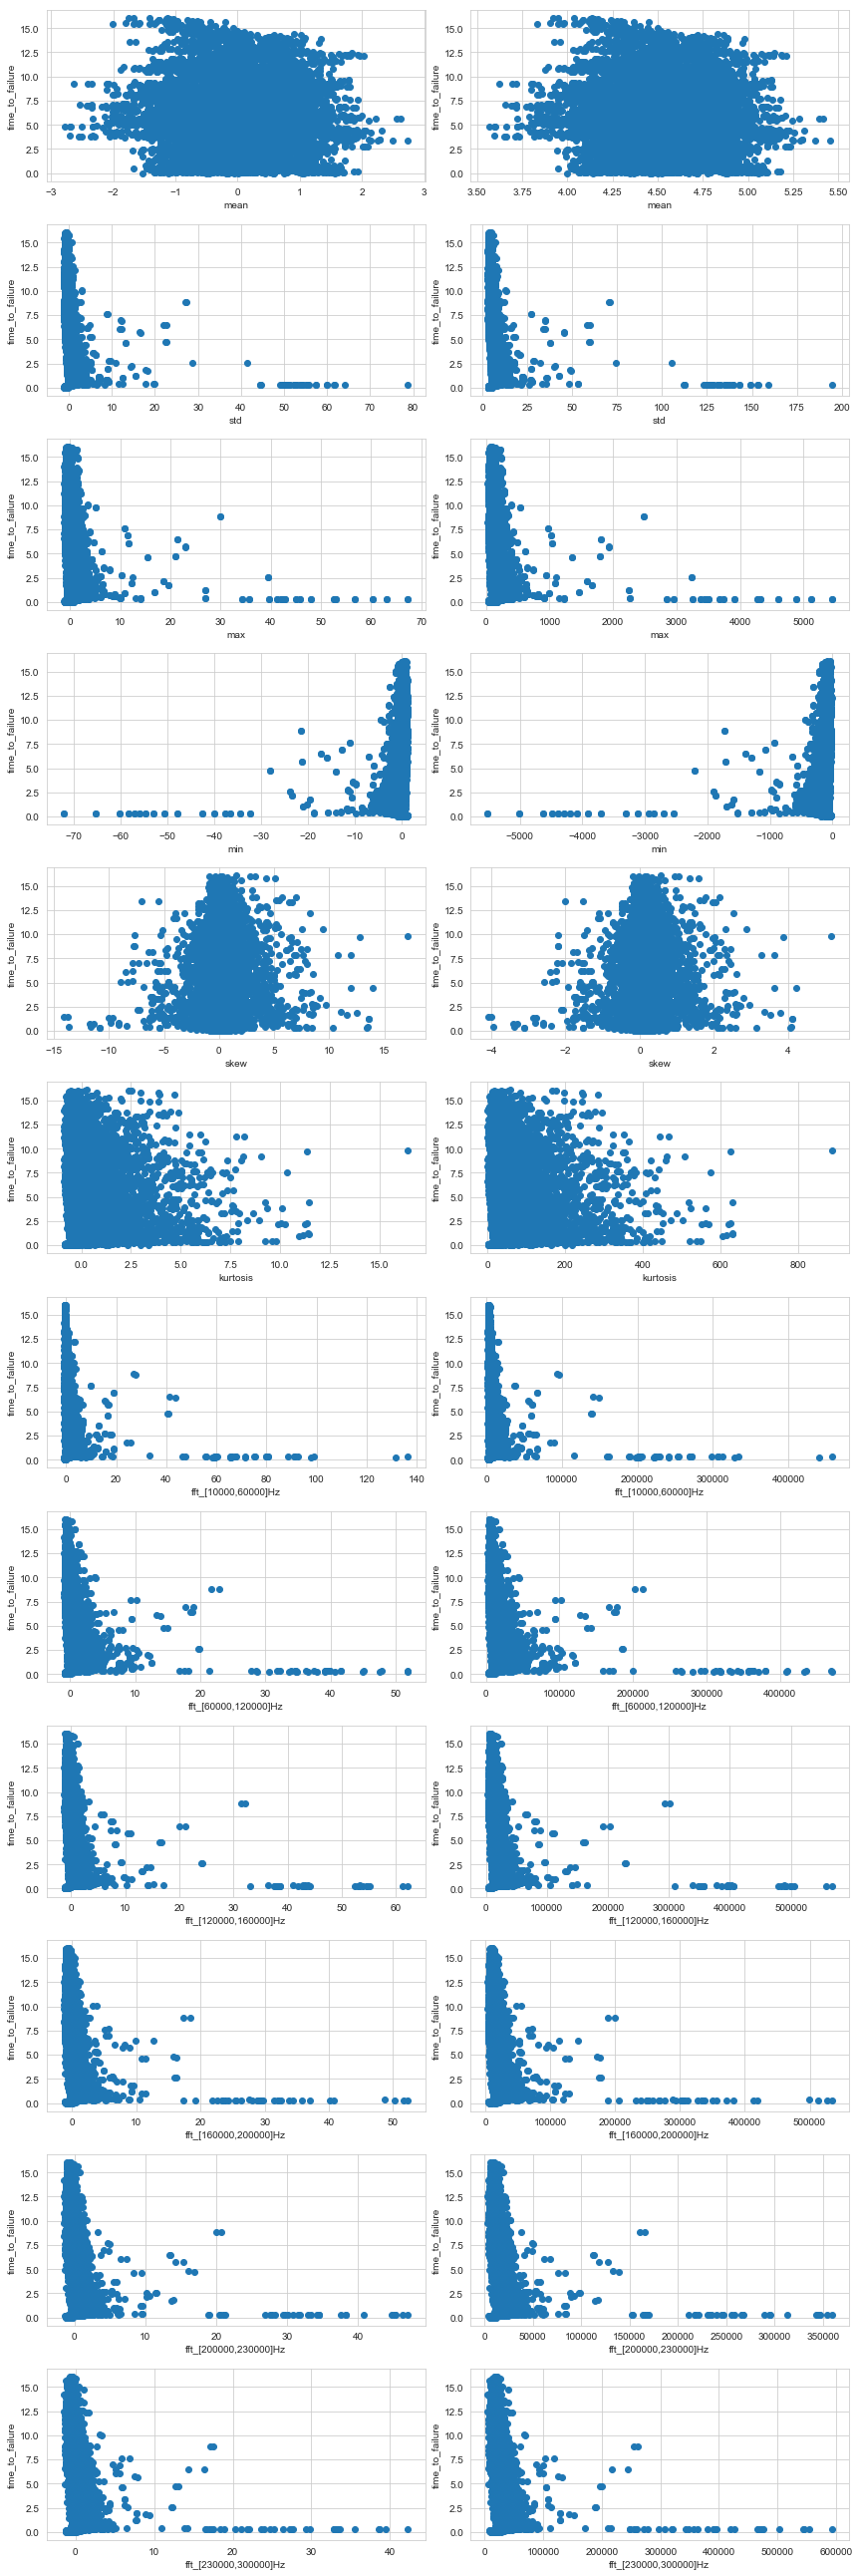

In [7]:
nrows = x_df.shape[1]
fig, axes = plt.subplots(nrows,2,figsize = (12,nrows*3))

for i,axis in enumerate(axes):
    axis[0].scatter(x_df[:,i],y_df)
    axis[0].set_xlabel(x_df_raw.columns[i])
    axis[0].set_ylabel('time_to_failure')
    
    axis[1].scatter(x_df_raw.iloc[:,i],y_df)
    axis[1].set_xlabel(x_df_raw.columns[i])
    axis[1].set_ylabel('time_to_failure')
    
plt.tight_layout()

#### 4) Split data into training and testing data

- Use 35% of data for testing

In [11]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(x_df,y_df,test_size=0.35,random_state = 0)

#### 5) Set up a model with linear regression

In [20]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_absolute_error

In [21]:
regressor_list = [LinearRegression(),Ridge(),Lasso()]
res_list = [cross_val_score(regressor,X_train,y_train.values.ravel(),
                      scoring='neg_mean_absolute_error',cv=5) for regressor in regressor_list]

for res in res_list:
    print('Mean CV score: {:.3f}, Std. Dev. of CV scores {:.3f}'.format(
        np.mean(res),np.std(res)))

Mean CV score: -2.660, Std. Dev. of CV scores 0.052
Mean CV score: -2.660, Std. Dev. of CV scores 0.052
Mean CV score: -2.939, Std. Dev. of CV scores 0.065


In [22]:
# Make a final benchmark model by training on the entire training data
from sklearn.base import clone
regressor_final_list = [clone(regressor) for regressor in regressor_list]
for regressor_final in regressor_final_list:
    regressor_final.fit(X_train,y_train.values.ravel())

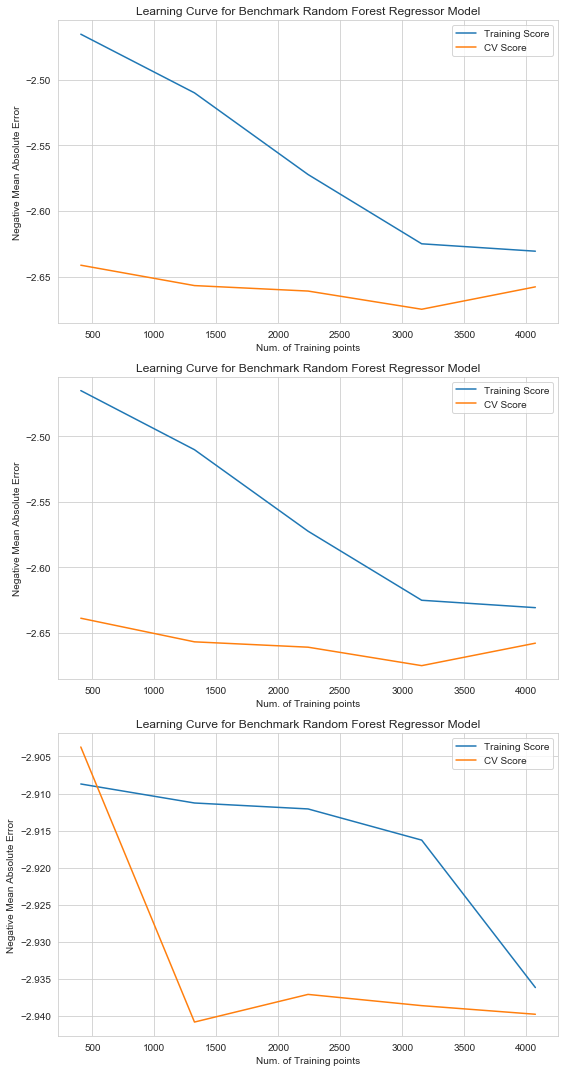

In [26]:
from sklearn.model_selection import learning_curve

fig, axes = plt.subplots(len(regressor_list),figsize=(8,5*len(regressor_list)))

for axis, regressor_final in zip(axes,regressor_final_list):
    train_sizes, train_scores, valid_scores = learning_curve(
        regressor_final,X_train,y_train.values.ravel(), cv=4,scoring='neg_mean_absolute_error')

    axis.plot(train_sizes,np.mean(train_scores,axis=1),label='Training Score')
    axis.plot(train_sizes,np.mean(valid_scores,axis=1),label='CV Score')
    axis.legend()
    axis.set_xlabel('Num. of Training points')
    axis.set_ylabel('Negative Mean Absolute Error')
    axis.set_title('Learning Curve for Benchmark Random Forest Regressor Model')
plt.tight_layout()

In [27]:
for regressor_final in regressor_final_list:
    for i,j in zip(data.columns,regressor_final.coef_):
        print("{} : {:.3f}".format(i,j))
    print("\n")

mean : -0.122
std : 1.290
max : -0.170
min : -0.557
skew : 0.155
kurtosis : -0.083
fft_[10000,60000]Hz : 0.161
fft_[60000,120000]Hz : -0.731
fft_[120000,160000]Hz : -0.581
fft_[160000,200000]Hz : -0.758
fft_[200000,230000]Hz : -0.302
fft_[230000,300000]Hz : -0.892


mean : -0.122
std : 1.287
max : -0.169
min : -0.557
skew : 0.155
kurtosis : -0.083
fft_[10000,60000]Hz : 0.162
fft_[60000,120000]Hz : -0.731
fft_[120000,160000]Hz : -0.581
fft_[160000,200000]Hz : -0.757
fft_[200000,230000]Hz : -0.302
fft_[230000,300000]Hz : -0.891


mean : -0.000
std : -0.000
max : -0.000
min : 0.000
skew : 0.000
kurtosis : -0.000
fft_[10000,60000]Hz : -0.000
fft_[60000,120000]Hz : -0.107
fft_[120000,160000]Hz : -0.000
fft_[160000,200000]Hz : -0.000
fft_[200000,230000]Hz : -0.000
fft_[230000,300000]Hz : -0.148




Text(0.5, 0, 'Sample #')

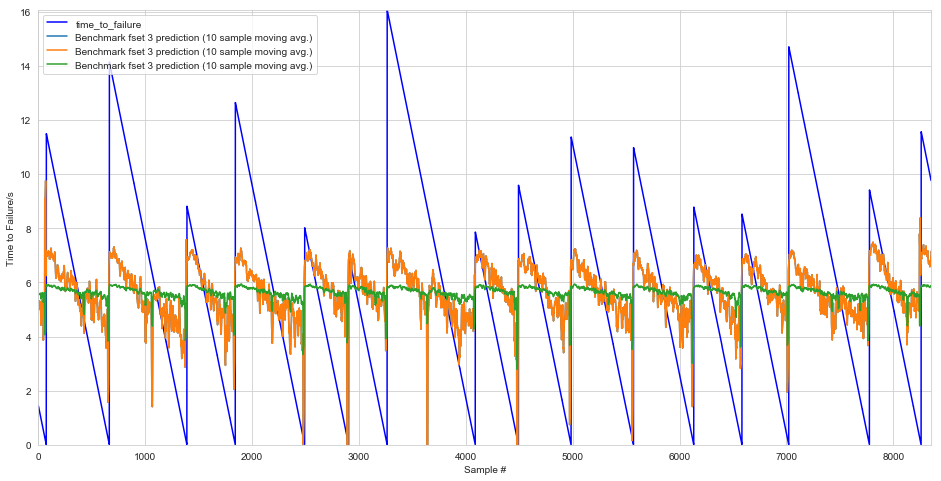

In [33]:
benchmark_pred_list = [pd.DataFrame(regressor_final.predict(scaler.transform(data.iloc[:,:-1])),
                              index=data.index,columns = ['Benchmark Prediction']) for 
                       regressor_final in regressor_final_list]

xdata = data.iloc[:,:-1]
fig,axis = plt.subplots(figsize=(16,8))
window = 10
axis.plot(data['time_to_failure'],'b')
for benchmark_pred in benchmark_pred_list:
    axis.plot(benchmark_pred.rolling(window).mean(),
          label="Benchmark fset 3 prediction ({} sample moving avg.)".format(window))
plt.legend()
plt.xlim((data.index[0],data.index[-1]))
plt.ylim((0,data['time_to_failure'].max()))
plt.ylabel('Time to Failure/s')
plt.xlabel('Sample #')